What factors would affect the outcome of a League of Legends match?
Predict the outcome of a game based on in-game values at the 15-minute mark?

https://www.kaggle.com/datasets/xmorra/league-of-legends-world-championship-2019

https://www.kaggle.com/datasets/bobbyscience/league-of-legends-soloq-ranked-games

https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min?select=high_diamond_ranked_10min.csv

1. Improve on 1st iteration model
2. Extend materials beyond course
3. Video use simple terms

References

https://github.com/chouhbik/Data-Analysis-League-of-Legends-Study
https://github.com/artoria-dev/data-science-lol

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



In [3]:
from google.colab import drive
# drive.mount('/content/drive')
data = pd.read_csv('high_diamond_ranked_10min.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

**Data Cleaning**

First check if data is complete with no missing values

In [4]:
#check for missing values
null_values = data.isnull().sum()

print(null_values)
print()

if null_values.sum() == 0:
    print("Data is complete")
else:
    print("Data is incomplete")

gameId                          0
blueWins                        0
blueWardsPlaced                 0
blueWardsDestroyed              0
blueFirstBlood                  0
blueKills                       0
blueDeaths                      0
blueAssists                     0
blueEliteMonsters               0
blueDragons                     0
blueHeralds                     0
blueTowersDestroyed             0
blueTotalGold                   0
blueAvgLevel                    0
blueTotalExperience             0
blueTotalMinionsKilled          0
blueTotalJungleMinionsKilled    0
blueGoldDiff                    0
blueExperienceDiff              0
blueCSPerMin                    0
blueGoldPerMin                  0
redWardsPlaced                  0
redWardsDestroyed               0
redFirstBlood                   0
redKills                        0
redDeaths                       0
redAssists                      0
redEliteMonsters                0
redDragons                      0
redHeralds    

Check if there are any duplicated games


In [5]:
#check if there are any duplicated games
duplicates = data['gameId'].duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


There are no duplicated games to remove

We believe that there is no need to remove outliers as it will help with prediction of game result
For example, if a team kills another team 100 times, they should win the game

Since we now know that every row is unique(no duplicated games), we can remove gameId

This dataset only consists of data pertaining to the first 10 minutes of the game, it is only possible to kill the dragon/herald once during that time. I will rename column names for better clarity

In [6]:
data = data.drop(columns=['gameId'])
data = data.rename(columns={"blueDragons": "blueDragon", "blueHeralds": "blueHerald", "redDragons": "redDragon", "redHeralds": "redHerald"})
data.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragon,blueHerald,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


As we are trying to figure out what contributes to a teams chances of winning, we will remove rows whereby no team has killed dragon/hearld or gotten first blood

This will make our data more meaningful, giving us more accurate analysis and model

In [7]:
#removing games where no herald is killed
data = data.loc[(data['blueHerald'] != 0) | (data['redHerald'] != 0)]
#removing games where no herald is killed
data = data.loc[(data['blueDragon'] != 0) | (data['redDragon'] != 0)]
#removing games where there are no kills
data = data.loc[(data['blueFirstBlood'] != 0) | (data['redFirstBlood'] != 0)]
#adding redWins as there is only blueWins
data['redWins'] = (1-data.blueWins)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2792 entries, 1 to 9871
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      2792 non-null   int64  
 1   blueWardsPlaced               2792 non-null   int64  
 2   blueWardsDestroyed            2792 non-null   int64  
 3   blueFirstBlood                2792 non-null   int64  
 4   blueKills                     2792 non-null   int64  
 5   blueDeaths                    2792 non-null   int64  
 6   blueAssists                   2792 non-null   int64  
 7   blueEliteMonsters             2792 non-null   int64  
 8   blueDragon                    2792 non-null   int64  
 9   blueHerald                    2792 non-null   int64  
 10  blueTowersDestroyed           2792 non-null   int64  
 11  blueTotalGold                 2792 non-null   int64  
 12  blueAvgLevel                  2792 non-null   float64
 13  blu

Split data into categorical and continuous data

In [8]:
continuousVars = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueDeaths',
               'blueAssists', 'blueEliteMonsters', 'blueTowersDestroyed',
               'blueTeamWardRetentionRatio', 'blueFirstBlood', 'blueDragon',
                  'blueHerald', 'blueFirstBlood', 'blueDragon', 'blueHerald']

categoricalVars = ['blueWins', 'blueFirstBlood', 'blueDragon', 'blueHerald', 'blueFirstBlood', 'blueDragon', 'blueHerald',
                   'blueFirstBlood', 'blueDragon', 'blueHerald', 'redWins']

**Exploratory data analysis**

We will first look at the win rate between Red and Blue team

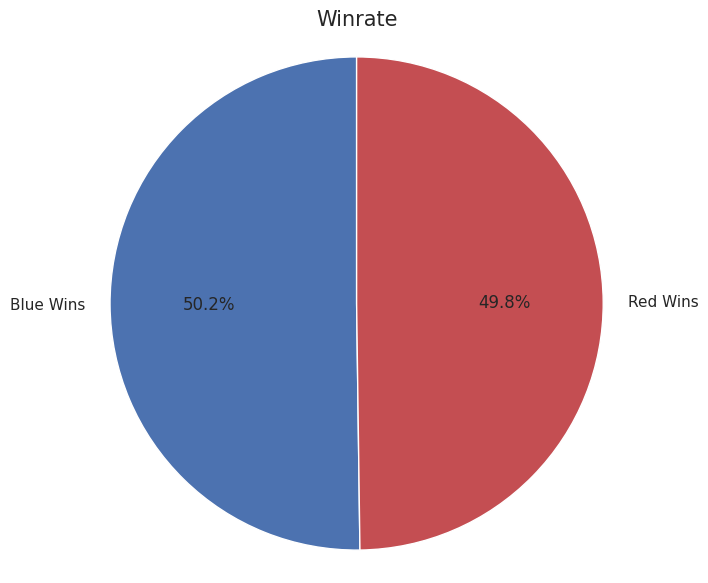

In [9]:
labels = 'Blue Wins', 'Red Wins'
sizes = [data.blueWins[data['blueWins'] == 1].count(), data.blueWins[data['blueWins'] == 0].count()]
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['b', 'r'])
ax1.axis('equal')
plt.title("Winrate", size=15)
plt.show()

Win rate is about 50% between blue and red team

**Win rate based on first blood**

First blood refers to the first kill of the game. On top of the 300 gold received, first blood also rewards an additional 100 gold

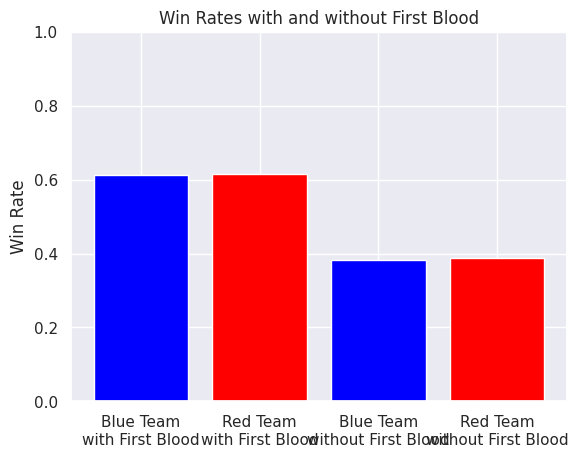

In [10]:
# calculate win rates for each team with and without first blood
blueWinsWithFirstBlood = (data.blueWins[data['blueFirstBlood'] == 1].sum() / data.blueWins[data['blueFirstBlood'] == 1].count())
redWinsWithFirstBlood = (data.redWins[data['redFirstBlood'] == 1].sum() / data.redWins[data['redFirstBlood'] == 1].count())
blueWinsWithoutFirstBlood = (data.blueWins[data['blueFirstBlood'] == 0].sum() / data.blueWins[data['blueFirstBlood'] == 0].count())
redWinsWithoutFirstBlood = (data.redWins[data['redFirstBlood'] == 0].sum() / data.redWins[data['redFirstBlood'] == 0].count())

# bar chart with win rates
labels = ['Blue Team\nwith First Blood', 'Red Team\nwith First Blood', 'Blue Team\nwithout First Blood', 'Red Team\nwithout First Blood']
win_rates = [blueWinsWithFirstBlood, redWinsWithFirstBlood, blueWinsWithoutFirstBlood, redWinsWithoutFirstBlood]
plt.bar(labels, win_rates, color=['blue', 'red', 'blue', 'red'])
plt.ylim(0, 1)
plt.ylabel('Win Rate')
plt.title('Win Rates with and without First Blood')

plt.show()

**Win rate with and without first Herald**

Herald is an important objective in the game and can heavily influence the state of the game

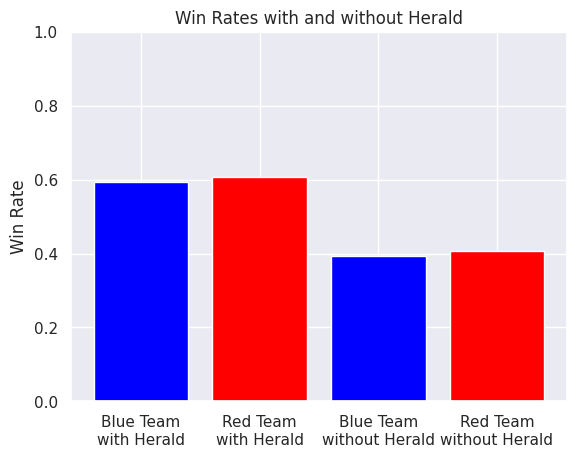

In [11]:
# calculate win rates for each team with and without herald
blueWinsWithHerald = (data.blueWins[data['blueHerald'] == 1].sum() / data.blueWins[data['blueHerald'] == 1].count())
redWinsWithHerald = (data.redWins[data['redHerald'] == 1].sum() / data.redWins[data['redHerald'] == 1].count())
blueWinsWithoutHerald = (data.blueWins[data['blueHerald'] == 0].sum() / data.blueWins[data['blueHerald'] == 0].count())
redWinsWithoutHerald = (data.redWins[data['redHerald'] == 0].sum() / data.redWins[data['redHerald'] == 0].count())

# bar chart with win rates
labels = ['Blue Team\nwith Herald', 'Red Team\nwith Herald', 'Blue Team\nwithout Herald', 'Red Team\nwithout Herald']
win_rates = [blueWinsWithHerald, redWinsWithHerald, blueWinsWithoutHerald, redWinsWithoutHerald]
plt.bar(labels, win_rates, color=['blue', 'red', 'blue', 'red'])
plt.ylim(0, 1)
plt.ylabel('Win Rate')
plt.title('Win Rates with and without Herald')

plt.show()

**Win rate with and without first Dragon**

Similar to the Herald, the dragon is also an important objective in the game

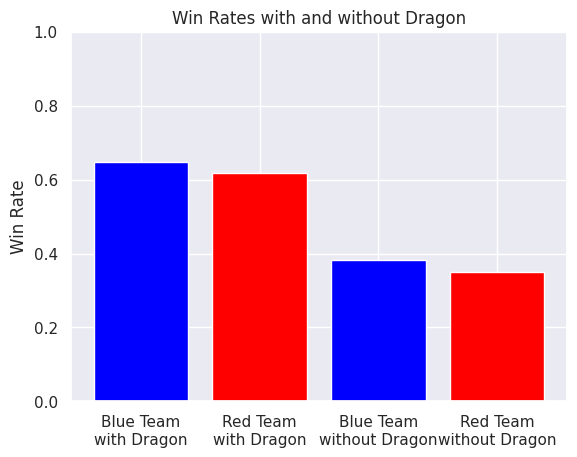

In [12]:
#calculate win rates for each team with and without dragon
blueWinsWithDragon = (data.blueWins[data['blueDragon'] == 1].sum() / data.blueWins[data['blueDragon'] == 1].count())
redWinsWithDragon = (data.redWins[data['redDragon'] == 1].sum() / data.redWins[data['redDragon'] == 1].count())
blueWinsWithoutDragon = (data.blueWins[data['blueDragon'] == 0].sum() / data.blueWins[data['blueDragon'] == 0].count())
redWinsWithoutDragon = (data.redWins[data['redDragon'] == 0].sum() / data.redWins[data['redDragon'] == 0].count())

#bar chart with win rates
labels = ['Blue Team\nwith Dragon', 'Red Team\nwith Dragon', 'Blue Team\nwithout Dragon', 'Red Team\nwithout Dragon']
win_rates = [blueWinsWithDragon, redWinsWithDragon, blueWinsWithoutDragon, redWinsWithoutDragon]
plt.bar(labels, win_rates, color=['blue', 'red', 'blue', 'red'])
plt.ylim(0, 1)
plt.ylabel('Win Rate')
plt.title('Win Rates with and without Dragon')

plt.show()

**Ploting heatmap**

We can plot a heatmap to show correlations between variables

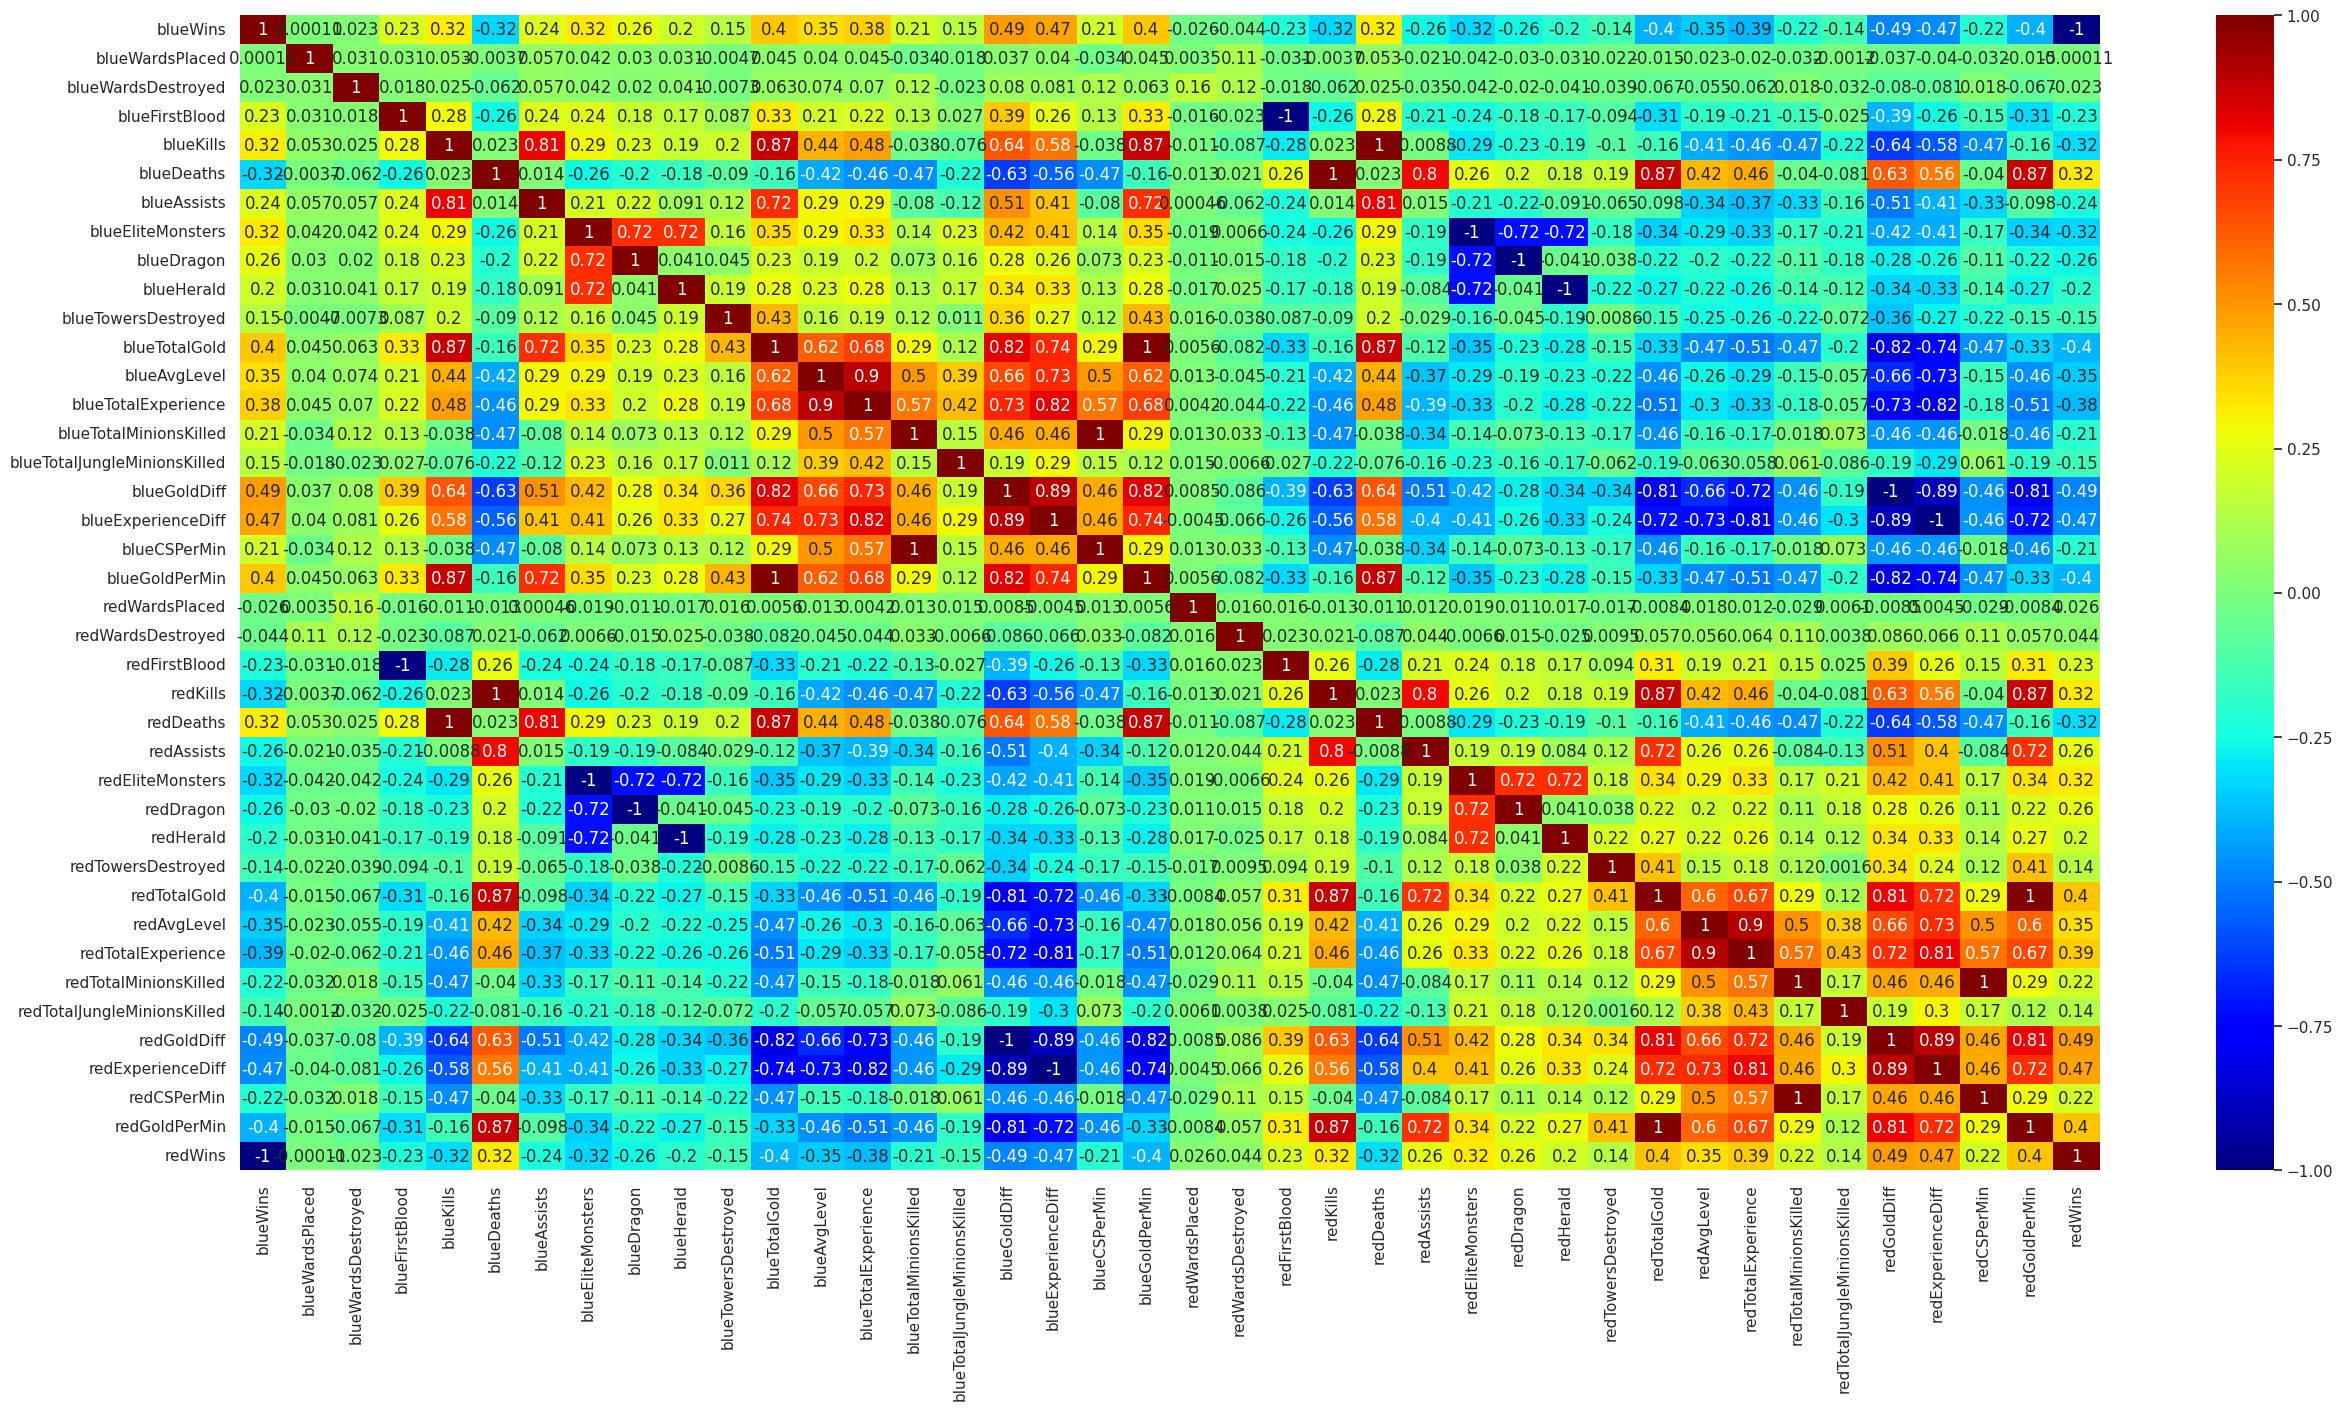

In [13]:
fig = plt.figure(figsize=(30, 15))
heatMap = sb.heatmap(data.loc[:].corr(), annot=True, cmap='jet')
heatMap.set_yticklabels(heatMap.get_yticklabels(), rotation=0)
heatMap.set_xticklabels(heatMap.get_xticklabels(), rotation=90)
plt.show()

We can see that blueGoldDiff has the highest correlation with blue team winning, with blueExpreienceDiff as a close second

We can plot a scattergraph for these two variables to see its relation

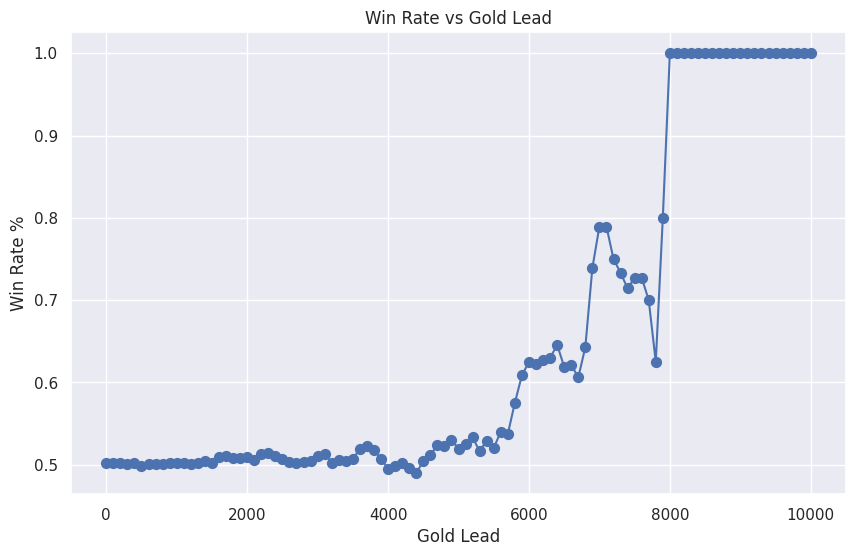

In [14]:
# Calculate the gold lead for each game
data["gold_lead"] = abs(data["blueGoldDiff"])
count = 0
# Calculate the win rate for each gold lead
win_rates = []
for i in range(0, 10001, 100):
    games_with_lead = data[data["gold_lead"] >= i]
    games_won = games_with_lead[games_with_lead["blueWins"] == 1]
    if games_with_lead.empty: #exclude when there are no games
        count+=1
    else:
        win_rate = games_won.shape[0] / games_with_lead.shape[0]
    win_rates.append(win_rate)

# Plot the win rate vs gold lead
plt.figure(figsize=(10, 6))
plt.scatter(range(0, 10001, 100), win_rates, s=50)
plt.plot(range(0, 10001, 100), win_rates)
plt.xlabel("Gold Lead")
plt.ylabel("Win Rate %")
plt.title("Win Rate vs Gold Lead")
plt.show()
#print(count)

We observe that as gold lead goes beyond around 5k, win rate starts to drastically increase

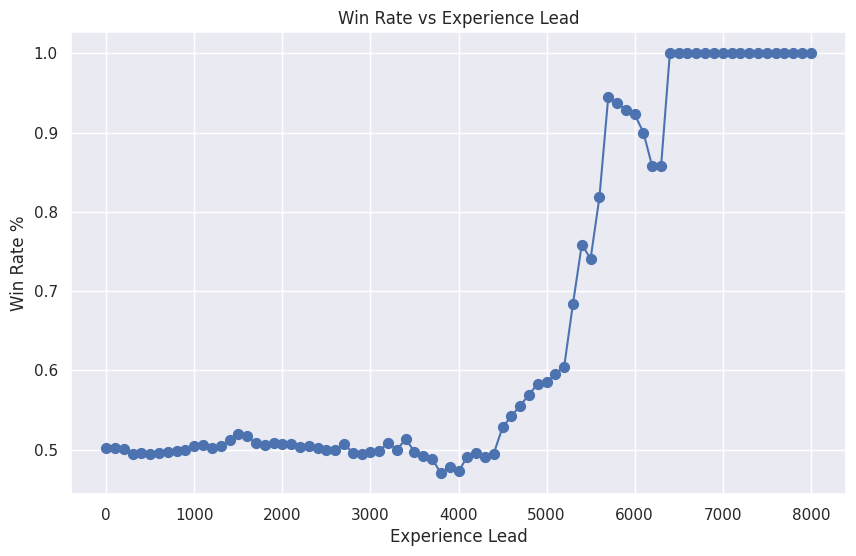

In [15]:
data["exp_lead"] = abs(data["blueExperienceDiff"])

# Calculate the win rate for each experience lead
win_rates = []
for i in range(0, 8001, 100):
    games_with_lead = data[data["exp_lead"] >= i]
    games_won = games_with_lead[games_with_lead["blueWins"] == 1]
    if games_with_lead.empty:
        win_rate = 0
    else:
        win_rate = games_won.shape[0] / games_with_lead.shape[0]
    win_rates.append(win_rate)

# Plot the win rate vs experience lead
plt.figure(figsize=(10, 6))
plt.scatter(range(0, 8001, 100), win_rates, s=50)
plt.plot(range(0, 8001, 100), win_rates)
plt.xlabel("Experience Lead")
plt.ylabel("Win Rate %")
plt.title("Win Rate vs Experience Lead")
plt.show()

We observe that as expereince lead goes above around 4.5k, win rate starts to drastically increase

**Training the Model**

This section will cover the creation of variables which are most likely going to have an impact of the probability of winning. This also is where I divide my testing and training data from my whole data set.

In [16]:
# create a train-test split
train_size = 0.8
df_train = pd.DataFrame(data)  # Predictor

df_train = df_train.sample(frac=train_size, random_state=0)
df_test = df_train.sample(frac=1-train_size, random_state=0)



# select x and y for training and testing
X_train = df_train.drop(['blueWins', 'redWins'], axis=1)
y_train = df_train['blueWins']
X_test = df_test.drop(['blueWins', 'redWins'], axis=1)
y_test = df_test['blueWins']

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2234
2234
447
447


In [17]:
print(len(df_train.columns))


42


**Recursive Feature Elimination (RFE)**

Initially we built the model with all the variables and found that there are many variables are insignificant (have high p-value). We need to reduce the number of variables.

We use RFE method to automatically select the optimal number of features for our model. Instead of specifying the number of features to select in advance with n_features_to_select, we use cross-validation to select the optimal number of features based on the performance of the model, to coarse tune the independent variables from 42 to 28. 


In [18]:
# create the RFE object and set the number of features to select to 10
# rfe = RFE(model, n_features_to_select=5)
model = LogisticRegression(max_iter=2000, C=0.1)

# rfe = RFE(model, n_features_to_select=10)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')

# fit the RFE object to the data
rfecv.fit(X_train, y_train)

# summarize the selection of the attributes
selected_features = [f for i, f in enumerate(X_train.columns) if rfecv.support_[i]]
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected Features: {}'.format(', '.join(selected_features)))
print('Cross-validated scores: {}'.format(rfecv.cv_results_['mean_test_score']))


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Optimal number of features: 29
Selected Features: blueWardsPlaced, blueWardsDestroyed, blueFirstBlood, blueKills, blueDeaths, blueAssists, blueEliteMonsters, blueDragon, blueHerald, blueTotalGold, blueTotalMinionsKilled, blueTotalJungleMinionsKilled, blueGoldDiff, blueExperienceDiff, blueCSPerMin, redWardsPlaced, redWardsDestroyed, redFirstBlood, redKills, redDeaths, redAssists, redEliteMonsters, redDragon, redHerald, redTowersDestroyed, redAvgLevel, redTotalMinionsKilled, redTotalJungleMinionsKilled, redGoldDiff
Cross-validated scores: [0.63071699 0.66964918 0.67995907 0.67861578 0.68980147 0.69741074
 0.6951726  0.69874901 0.70098916 0.70053972 0.70188702 0.68979846
 0.68935103 0.69293045 0.69651087 0.69695629 0.70143056 0.70052969
 0.70277184 0.70411713 0.70635427 0.70859141 0.72247168 0.72381497
 0.72336754 0.7211274  0.71889026 0.72157583 0.72426039 0.72381397
 0.72292012 0.72336453 0.71978311 0.72067796 0.72292012 0.71754998
 0.71844484 0.72023355 0.71933568 0.7148594 ]


A reduction from 42 to 28 features using RFECV is a good start, but whether 28 features is still too many for logistic regression depends on several factors, such as the size and complexity of your dataset, the amount of noise in the data, and the degree of multicollinearity among the features.

In [19]:
# create a new logistic regression object with the selected features

model = LogisticRegression(max_iter=2000, C=0.1)
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

# len(X_test.values)

# fit the model on the training data using the selected features
model.fit(X_train_selected, y_train)

# evaluate the performance of the model on the test data
test_score = model.score(X_test_selected, y_test)
print('Test score: {}'.format(test_score))

Test score: 0.7360178970917226


We know that the logistic regression model outputs probabilities (values between 0 to 1). In order to make predictions on train data (y_train_pred), we need to convert these probabilities to 1s and 0s. For this we need to decide a threshold probability value above which all the probability values will be classified as 1 and the values below it will be classified as 0. For that, we need to plot the ROC (Receiver Operating Characteristic) curve.

An ROC curve is nothing but a graph of True Positive Rate (TPR) v/s False Positive Rate (FPR) at different classification thresholds. Please refer to the Confusion Matrix given below to understand the terms.

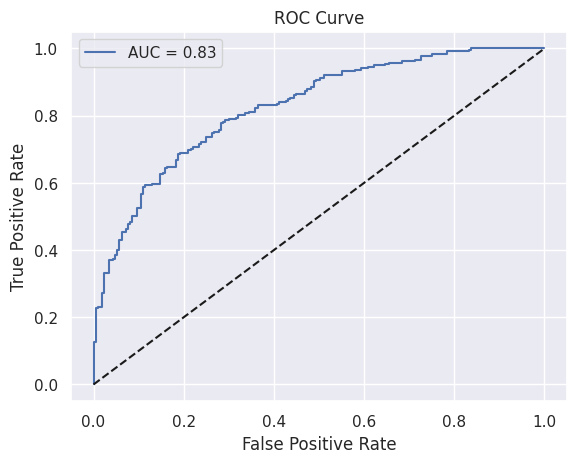

In [20]:
# predict probabilities for test set
# X_test_selected_new = X_test[selected_features]
y_test_proba = model.predict_proba(X_test_selected)[:, 1]

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# compute AUC-ROC score
auc_score = roc_auc_score(y_test, y_test_proba)

# plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


**Improvement**

Could we reduce the features and improve the model?

We observe that there are some features which might not directly affect the outcome as it only aids in better decision making. These features are "blueWardsPlaced, blueWardsDestroyed".

Since League of Legends is a Team vs Team game, it only makes sense to take the Net data and the same blue & red features should be present. This can be easily obtain using the values we created through feature engineering.

**Trying out different models**

Over here we experiment different models. We tried the Random forest algorithm and fine tune the parameters to product an improved accuracy result. We also have to recognise that one of the biggest problems in machine learning is overfitting, however this won't happen thanks to the random forest classifier. If there are enough trees in the forest, the classifier will not overfit the model.

In [21]:
df_train['blueTeamWardRetentionRatio'] = (df_train.blueWardsPlaced - df_train.redWardsDestroyed)/df_train.blueWardsPlaced
df_train['blueTeamNetKills'] = (df_train.blueKills - df_train.redKills)
df_train['blueTeamJungleMinionsKilledDiff'] = (df_train.blueTotalJungleMinionsKilled - df_train.redTotalJungleMinionsKilled)
df_train['blueTeamMinionsKilledDiff'] = (df_train.blueTotalMinionsKilled - df_train.redTotalMinionsKilled)
df_train['blueTeamAvgLevelDiff'] = (df_train.blueAvgLevel - df_train.redAvgLevel)
df_train['blueTeamCsPerMinuteDiff'] = (df_train.blueCSPerMin - df_train.redCSPerMin)
df_train['blueTeamGoldPerMinuteDiff'] = (df_train.blueGoldPerMin - df_train.redGoldPerMin)

df_train = df_train.sample(frac=train_size, random_state=0)
df_test = df_train.sample(frac=1-train_size, random_state=0)

# select x and y for training and testing
X_train = df_train.drop(['blueWins', 'redWins'], axis=1)
y_train = df_train['blueWins']
X_test = df_test.drop(['blueWins', 'redWins'], axis=1)
y_test = df_test['blueWins']

newly_feature_engineered = ['blueTeamWardRetentionRatio', 'blueTeamNetKills', 'blueTeamJungleMinionsKilledDiff','blueTeamMinionsKilledDiff', 'blueTeamAvgLevelDiff', 'blueTeamCsPerMinuteDiff', 'blueTeamGoldPerMinuteDiff']
X_train_selected = df_train.loc[:, newly_feature_engineered]
X_test_selected = df_test.loc[:, newly_feature_engineered]

In [22]:
# create a new Random Forest classifier object
rf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=0)

# fit the model on the training data
rf.fit(X_train_selected, y_train)

# predict the target variable for test data
y_pred = rf.predict(X_test_selected)

# evaluate the performance of the model on the test data
test_score = accuracy_score(y_test, y_pred)
print('Test score: {}'.format(test_score))

Test score: 0.8067226890756303


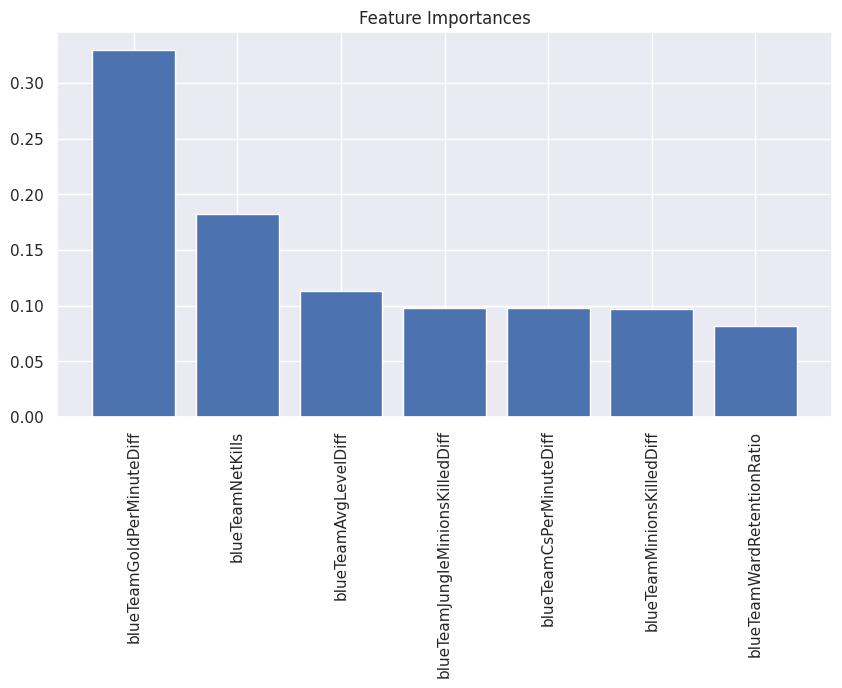

In [23]:
from sklearn.ensemble import RandomForestClassifier

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_selected.columns

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train_selected.shape[1]), importances[indices])
plt.xticks(range(X_train_selected.shape[1]), features[indices], rotation=90)
plt.show()

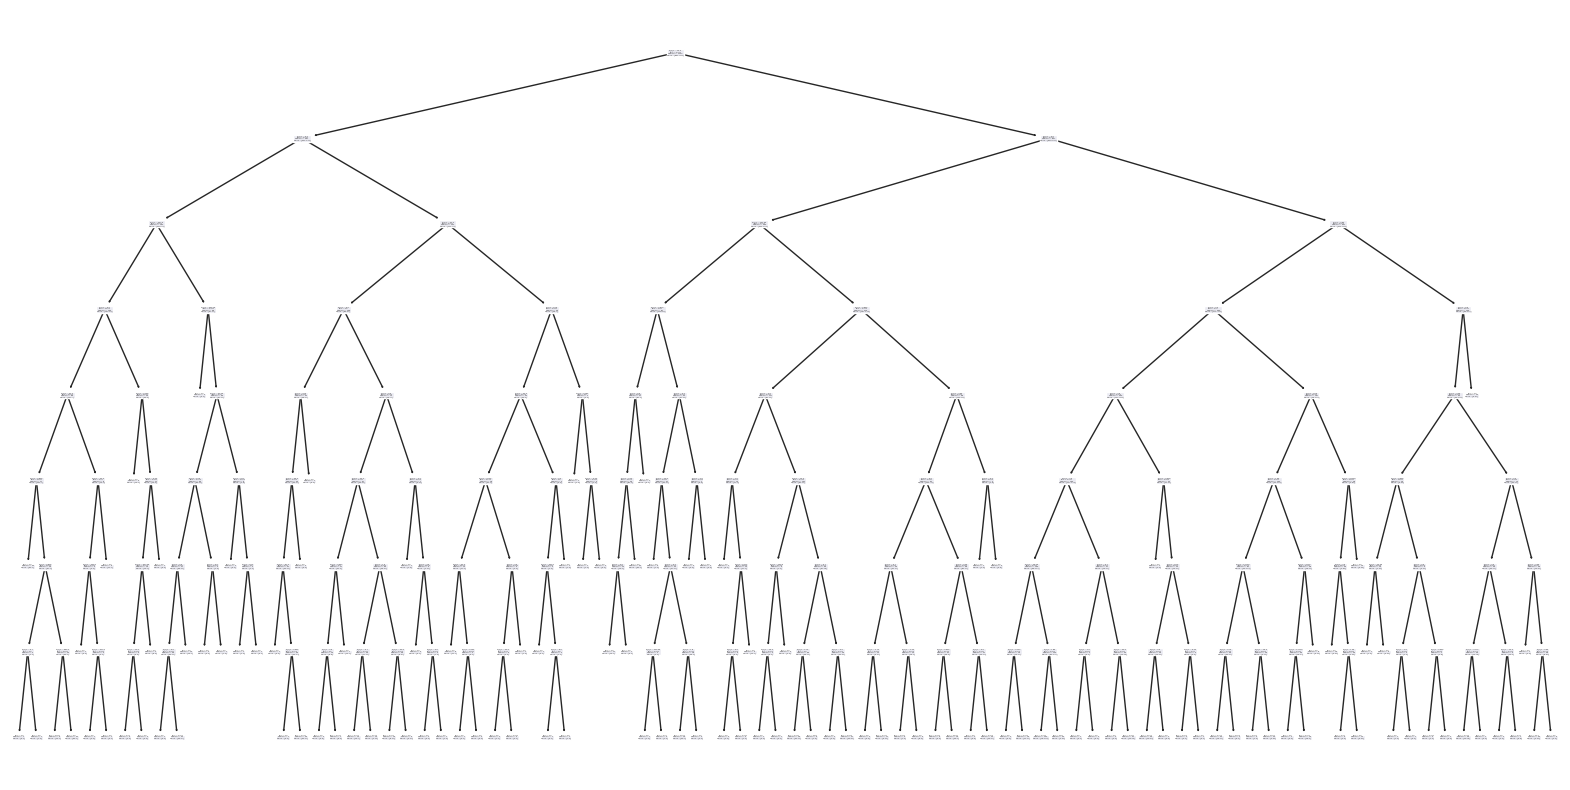

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# get the first decision tree from the Random Forest
tree = rf.estimators_[0]

# plot the decision tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(tree, ax=ax)
plt.show()

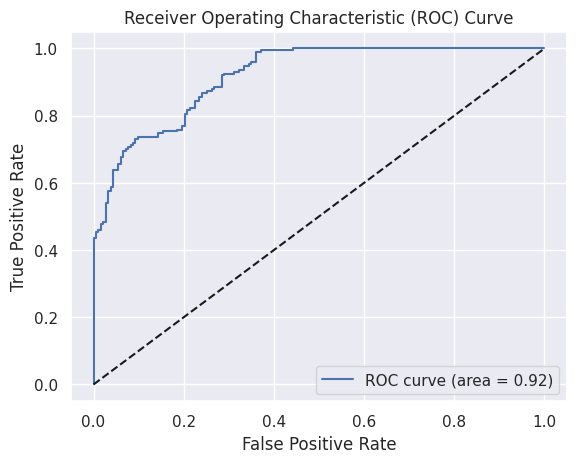

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# predict probabilities for test data
y_prob = rf.predict_proba(X_test_selected)[:, 1]

# calculate fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Can we further improve our model?

We will apply min max normalizatoin on variables with a large range

In [26]:


# min-max normalization form -1 to 1
min_val = data['blueExperienceDiff'].min()
max_val = data['blueExperienceDiff'].max()
data['blueExperienceDiff'] = (2 * (data['blueExperienceDiff'] - min_val) / (max_val - min_val)) - 1

# min-max normalization form 0 to 1
min_val = data['blueTotalGold'].min()
max_val = data['blueTotalGold'].max()
data['blueTotalGold'] = (data['blueTotalGold'] - min_val) / (max_val - min_val)

# min-max normalization form 0 to 1
min_val = data['blueTotalExperience'].min()
max_val = data['blueTotalExperience'].max()
data['blueTotalExperience'] = (data['blueTotalExperience'] - min_val) / (max_val - min_val)

# min-max normalization form -1 to 1
min_val = data['blueGoldDiff'].min()
max_val = data['blueGoldDiff'].max()
data['blueGoldDiff'] = (2 * (data['blueGoldDiff'] - min_val) / (max_val - min_val)) - 1

# min-max normalization form 0 to 1
min_val = data['redTotalGold'].min()
max_val = data['redTotalGold'].max()
data['redTotalGold'] = (data['redTotalGold'] - min_val) / (max_val - min_val)

# min-max normalization form 0 to 1
min_val = data['redTotalExperience'].min()
max_val = data['redTotalExperience'].max()
data['redTotalExperience'] = (data['redTotalExperience'] - min_val) / (max_val - min_val)

# min-max normalization form -1 to 1
min_val = data['redGoldDiff'].min()
max_val = data['redGoldDiff'].max()
data['redGoldDiff'] = (2 * (data['redGoldDiff'] - min_val) / (max_val - min_val)) - 1

# min-max normalization form -1 to 1
min_val = data['redExperienceDiff'].min()
max_val = data['redExperienceDiff'].max()
data['redExperienceDiff'] = (2 * (data['redExperienceDiff'] - min_val) / (max_val - min_val)) - 1

# min-max normalization form 0 to 1
min_val = data['redGoldPerMin'].min()
max_val = data['redGoldPerMin'].max()
data['redGoldPerMin'] = (data['redGoldPerMin'] - min_val) / (max_val - min_val)

# min-max normalization form 0 to 1
min_val = data['blueGoldPerMin'].min()
max_val = data['blueGoldPerMin'].max()
data['blueGoldPerMin'] = (data['blueGoldPerMin'] - min_val) / (max_val - min_val)

In [27]:
norm_data = ['blueExperienceDiff', 'blueTotalGold', 'blueTotalExperience', 'blueGoldDiff', 
                  'redTotalGold', 'redTotalExperience', 'redGoldDiff', 'redExperienceDiff',
                  'redGoldPerMin', 'blueGoldPerMin']

X_train_selected = X_train[norm_data]
X_test_selected = X_test[norm_data]

# fit the model on the training data using the selected features
model.fit(X_train_selected, y_train)

# evaluate the performance of the model on the test data
test_score = model.score(X_test_selected, y_test)
print('Test score: {}'.format(test_score))

Test score: 0.7002801120448179
